In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime as tm
import datetime
import seaborn as sns
from lifelines import CoxPHFitter,LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter
from lifelines.datasets import load_rossi
from reliability.Fitters import Fit_Weibull_3P
from scipy.optimize import minimize
t = time.time()
PHMinput = 0

In [75]:
### converts varying datatypes into unix time for easier computation
def convert2unix(time):
    ### for string format
    if type(time) == type('hey'):
        time = (tm.strptime(time,'%Y-%m-%dT%H:%M:%S') - tm(1970,1,1,0,0,0)).total_seconds()
        #time = tm.strptime(time,'%m/%d/%y %H:%M:%S %p').timestamp()
    ### for datetime format
    elif type(time) == tm:
        time = time.timestamp()
        print('tm')
    ### this is already in unix time
    elif type(time) == float:
        #print(time)
        pass
    ### for pandas format
    elif type(time) == pd._libs.tslibs.timestamps.Timestamp:
        time = time.timestamp()
    ### notifies the user that the format is not recognized
    else:
        print('NONE OF THE ABOVE')
        print(type(time))
    return time


In [76]:
def find_zero(lst, lastfail, currfail):
    newlst = []
    for item in lst:
        if item >= 0 and item < currfail - lastfail:
            newlst.append(item + 1) 
    return(newlst)

In [77]:

### $ Filename imported by field engineer
filename = 'C:/Users/sambe/Desktop/Chevron Project/chevron_test_template.xlsx'
### list of all possible motor variable inputs
allvars = ['Inlet Flowrate',
 'Inlet Pressure',
 'Outlet Pressure',
 'Inlet Temperature',
 'Column Level',
 'STD API',
 'Pump Driver Vibration',
 'Pump Vibration',
 'Sister Pump Driver Vibration',
 'Sister Pump Vibration']
### $ Convert to pandas data frame
df = pd.read_excel(filename, sheet_name = 'Time-Series Data')
print(f'Elapsed time is {(time.time() - t)/60} minutes')
### grab columns from input dataframe
a = df.columns

### $ Get the number of rows and columns in the file (# of covariates and sampling will probably be different)
number_rows = len(df.index)
number_cols = len(df.columns)


Elapsed time is 1.465512184302012 minutes


In [78]:
### formatting
df.columns = df.iloc[0].fillna('Unnamed')
df.drop(0, inplace = True)
df.reset_index(drop = True, inplace = True)
df

,Pen Name:,16FI226,Units: MBPD,Unnamed,...,Unnamed,EMPTY 1,EMPTY 2,EMPTY 3
0,NaN,NaN,NaN,nan,...,nan,NaN,NaN,NaN
1,2038.28,2018-02-20T15:01:30,GOOD,nan,...,nan,NaN,NaN,NaN
2,2039.22,2018-02-20T15:01:59,GOOD,nan,...,nan,NaN,NaN,NaN
3,2039.06,2018-02-20T15:02:29,GOOD,nan,...,nan,NaN,NaN,NaN
4,2039.22,2018-02-20T15:03:29,GOOD,nan,...,nan,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
507005,NaN,NaN,NaN,nan,...,nan,NaN,NaN,NaN
507006,NaN,NaN,NaN,nan,...,nan,NaN,NaN,NaN
507007,NaN,NaN,NaN,nan,...,nan,NaN,NaN,NaN
507008,NaN,NaN,NaN,nan,...,nan,NaN,NaN,NaN


In [79]:

### $ Create empty data frames with the three points per covariate (value, times, good/bad)
variables = pd.DataFrame([])
times = pd.DataFrame()
goodbad = pd.DataFrame()
### $ Sort out whole excel file to place the column in the right data frame (value, times, good/bad)
### $ Relabeled with Variable i names
### $ Iterates over the number of columns
t = time.time()
missingcols = []
counter = 0
for i in range(number_cols):
    ### $ Puts column title into str
    str = df.columns[i]
    ### $ if searches for a title that starts with 'Pen Name'
    if str.startswith('Pen Name'):
        ### $ takes variables from column and puts in separate 'variables' dataframe
        s = df.iloc[1:,i]
        variables = pd.concat([variables,s.rename('Value')], axis = 1)
    ### $ elif searches for a title that starts with 'Units'
    elif str.startswith('Units'):
        ### $ takes variables from column and puts in separate 'goodbad' dataframe
        s = df.iloc[1:,i]
        goodbad = pd.concat([goodbad,s.rename('GOOD/BAD')],axis = 1)
    ### $ This is for the blank columns in between variable columns
    elif str.startswith('Unnamed'):
        ### $ Skips over empty columns
        continue
    elif str.startswith('EMPTY 1'):
        variables = pd.concat([variables,pd.DataFrame([np.nan])],axis = 1)
    elif str.startswith('EMPTY 2'):
        times = pd.concat([times,pd.DataFrame([np.nan])],axis = 1)
        missingcols.append(int((i-1)/4))
    elif str.startswith('EMPTY 3'):
        goodbad = pd.concat([goodbad,pd.DataFrame([np.nan])],axis = 1)
    ### $ This is an else because the pen names vary and will be different for every pump/variable
    else:
        ### $ takes variables from column and puts in separate 'times' dataframe
        s = df.iloc[1:,i].apply(convert2unix)
        times = pd.concat([times,s.rename('Time')], axis = 1)
print(f'Elapsed time is {(time.time() - t)/60} minutes')
### relabels times, goodbad, and variables to have the same column names
times.columns = allvars
goodbad.columns = allvars
variables.columns = allvars

Elapsed time is 0.4875029961268107 minutes


In [80]:
### formatting
times.drop(0,inplace = True)
times.reset_index(drop = True, inplace = True)
variables.drop(0,inplace = True)
variables.reset_index(drop = True, inplace = True)
goodbad.drop(0,inplace = True)
goodbad.reset_index(drop = True, inplace = True)

In [81]:
### finds the available vairables for that motor (i.e. those variables that were input into the program)
availvars = []
for i in range(len(times.columns)):
    if i in missingcols:
        pass
    else:
        availvars.append(times.columns[i])

In [82]:
availvars

['Inlet Flowrate',
 'Inlet Pressure',
 'Outlet Pressure',
 'Pump Driver Vibration',
 'Pump Vibration']

In [83]:
### selects only the columns with variables in them
times = times[availvars]
goodbad = goodbad[availvars]
variables = variables[availvars]

In [84]:
### formatting for later
times = times.append(pd.Series([], dtype = np.float64),ignore_index = True)

In [85]:
### $ interpolates for BAD Values
### $ Excludes last row because you can't interpolate a machine being on or off
t = time.time()
for j in range(len(variables.columns)):
    for i in range(len(variables.iloc[:,j].dropna())):
        str = goodbad.iloc[i,j]
        ### $ If the value is bad and the value has no prior value to interpolate from, just use next good value
        ### $ Needs improvement: could back interpolate and take care of case in which there are consecutive bad values     
        if str.startswith('B'):# and i == 0:
            variables.iloc[i,j] = variables.iloc[i-1,j]
            goodbad.iloc[i,j] = 'OK'
        ### $ Else if bad, then interpolate between the two good points
#        elif str.startswith('B'):
#            t1 = times.iloc[i-1,j]
#            t2 = times.iloc[i,j]
#            t3 = times.iloc[i+1,j]
#            a = variables.iloc[i-1,j]
#            c = variables.iloc[i+1,j]
#            variables.iloc[i,j] = ((t2-t1)/(t3-t1))*(c-a)+a
#            goodbad.iloc[i,j] = 'INT'
print(f'Elapsed time is {(time.time() - t)/60} minutes')

Elapsed time is 0.720980147520701 minutes


In [86]:
### $ Align times via binning
### $ kappa designates the grouping size
### $ Any timestamp outside of the bin will be group later



### $ Sets to dataframes: windows and shutters. windows is the number row that is being looked at for that variable. shutters is end of the length of that variable
### $ column titles designate which variable is being investigated
windows = pd.DataFrame()
shutters = pd.DataFrame()
for j in range(len(variables.columns)):
    w = pd.DataFrame([0], columns = [f'{j}'])
    windows = pd.concat([windows, w], axis = 1)
    temp = variables.iloc[:,j]
    s = pd.DataFrame([len(temp)], columns = [f'{j}'])
    shutters = pd.concat([shutters, s], axis = 1)
    
binsize = 60*2#seconds

### $ abstime is the merged and grouped times of all the variables
abstime = pd.DataFrame([])
### $ vars is the merged and grouped variables
vars = pd.DataFrame([], columns = allvars)

In [ ]:
############# binsize for binning in seconds
binsize = 60*2
#############
timestart = times.dropna(thresh = 1).min().min()
timenow = timestart
timeend = times.dropna(thresh = 1).max().max()
t = time.time()

abstime = []
vars = []
### Flag denotes if the timenow is less than or equal to timeend
Flag = 1
while Flag:
    ### vlist is list of variables in that timebin
    vlist = []
    ### below iterates over columns
    for j in range(len(variables.columns)):
        ### Flag1 denotes if the end of the available times in the column has been reached
        Flag1 = 1
        ### v is the list of variables that fall within the time bin (say three flowrates occur within that two minute timebin)
        v = []
        while Flag1:
            ###
            timecomp = times.iloc[windows.iloc[0,j],j]
            if timecomp >= timenow and timecomp < timenow + binsize:
                v.append(variables.iloc[windows.iloc[0,j],j])
                windows.iloc[0,j] += 1 
            elif timecomp >= timenow + binsize:
                Flag1 = 0
            elif np.isnan(times.iloc[windows.iloc[0,j],j]):
                Flag1 = 0   

            else:
                print('HELP')
        if len(v) == 0:
            v = np.nan
        else:
            v = sum(v)/float(len(v)) 
        vlist.append(v)

        
    abstime.append(timenow)
    vars.append(vlist)
    timenow += binsize
    if timenow > timeend:
        Flag = 0
print(f'Elapsed time is {(time.time() - t)/60} minutes')

In [ ]:
abstime = pd.DataFrame(abstime, columns = ['Time'])

In [ ]:
vars = pd.DataFrame(vars, columns = availvars)

In [ ]:
for j in range(len(vars.columns)):
    for i in range(len(vars)):
        if np.isnan(vars.iloc[i,j]) and i == 0:
            vars.iloc[i,j] = vars.iloc[i+1,j]
        elif np.isnan(vars.iloc[i,j]):
            vars.iloc[i,j] = vars.iloc[i-1,j]


In [ ]:
vars

In [ ]:
availvarsplustime = ['Time']
for s in availvars:
    availvarsplustime.append(s)


In [ ]:


fixed = pd.concat([abstime,vars], axis = 1)
fixed.columns = availvarsplustime
fixed.dropna(thresh = 2, inplace = True)



fixed.to_excel('interpolatedvar.xlsx')


In [ ]:
fixed

In [ ]:

filename = 'C:/Users/sambe/Desktop/Chevron Project/chevron_test_template.xlsx'
faildata = pd.read_excel(filename, sheet_name = 'Failure Mode & Date')

In [ ]:
faildata

In [ ]:
list = []
#####
minflowrate = fixed['Inlet Flowrate'].mean()
#####
flowdiff = fixed['Inlet Flowrate'] - minflowrate
for item in flowdiff:
    if item > 0:
        list.append('On')
    else:
        list.append('Off')
fixed['Status'] = list

fixed = fixed[fixed['Status'] == 'On']

fixed.reset_index(drop = True, inplace = True)

fixed

In [ ]:
minflowrate

In [ ]:
onoffint = 60*60

off = pd.DataFrame(fixed[fixed['Time'].diff(periods = -1) < -onoffint])
offindex = off.index
off.reset_index(drop = True, inplace = True)
off['Time'] = off['Time'] - timestart

on = pd.DataFrame(fixed[fixed['Time'].diff(periods = 1) > onoffint])
onindex = on.index
on.reset_index(drop = True, inplace = True)
on['Time'] = on['Time'] - timestart

onindex

In [ ]:
### Fix to time on
timestart = fixed['Time'].min()
timestart

timeshifted = fixed['Time'] - timestart

timeshifted

timeoff = on['Time'] - off['Time']

timeoff

timeoff.index = onindex

fixedlist = timeshifted.tolist()

for index in fixed.index:
    if index in timeoff.index:
        fixedlist[index:] -= (timeoff[index] - binsize)

timeonlist = pd.DataFrame(fixedlist,columns = ['Time On'])

timeonlist


fixed = pd.concat([timeonlist,fixed], axis = 1)

fixed

In [ ]:
faildata['Date'] = faildata['Date'].apply(convert2unix)

In [ ]:
faildata.sort_values(by = ['Date'], inplace = True)

In [ ]:
allfailmodes = ['Motor_Distorted','Broken_Valve','Valve_Alignment','Broken_Impeller','Leaking_Valve', 'Cracked_Seal']
allfailmodeswindows = [60*60*24*7,60*60*24*2,60*60*24*2,60*60*24*5,60*60*24*2,60*60*24*2]

In [ ]:
failmodeswindows = pd.DataFrame([allfailmodeswindows], columns = allfailmodes)

In [ ]:
failmodeswindows

In [ ]:
list = []
for mode in faildata['Mode']:
    list.append(failmodeswindows[mode][0])

In [ ]:
faildata['Time Window'] = list

In [ ]:
faildata.reset_index(drop = True, inplace = True)

In [ ]:
faildata

In [ ]:
list = []
for faildate in faildata['Date']:
    list.append(fixed.loc[(fixed['Time'] < faildate)]['Time On'].max())
    

In [ ]:
faildata['Time On'] = list

In [ ]:
faildata

In [ ]:
list = []
for faildate in faildata['Time On']:
    faildiff = faildate - faildata['Time On']
    Flag = 0
    for diff in faildiff:
        if diff > 0 and diff < faildata.loc[faildata['Time On'] == faildate]['Time Window'].values:
            x = diff
            Flag = 1
    if Flag == 1:
        list.append(x)
    else:
        list.append(faildata.loc[faildata['Time On'] == faildate]['Time Window'].values[0])
        

In [ ]:
faildata.loc[faildata['Time On'] == faildate]['Time Window'].values[0]

In [ ]:
list

In [ ]:
faildata.drop(axis = 1,columns = 'Time Window', inplace = True)

In [ ]:
faildata['Time Window'] = list

In [ ]:
faildata

list = []
#####
minflowrate = fixed['Inlet Flowrate'].mean()
#####
flowdiff = fixed['Inlet Flowrate'] - minflowrate
for item in flowdiff:
    if item > 0:
        list.append('On')
    else:
        list.append('Off')
fixed['Status'] = list

fixed = fixed[fixed['Status'] == 'On']

fixed.reset_index(drop = True, inplace = True)

fixed

In [ ]:
onoffint = 60*60

off = pd.DataFrame(fixed[fixed['Time'].diff(periods = -1) < -onoffint])
offindex = off.index
off.reset_index(drop = True, inplace = True)
off['Time'] = off['Time'] - timestart

on = pd.DataFrame(fixed[fixed['Time'].diff(periods = 1) > onoffint])
onindex = on.index
on.reset_index(drop = True, inplace = True)
on['Time'] = on['Time'] - timestart

onindex

### Fix to time on
timestart = fixed['Time'].min()
timestart

timeshifted = fixed['Time'] - timestart

timeshifted

timeoff = on['Time'] - off['Time']

timeoff

timeoff.index = onindex

fixedlist = timeshifted.tolist()

for index in fixed.index:
    if index in timeoff.index:
        fixedlist[index:] -= timeoff[index]

timeonlist = pd.DataFrame(fixedlist,columns = ['Time On'])

timeonlist


fixed = pd.concat([timeonlist,fixed], axis = 1)

fixed

In [ ]:
labeled = pd.DataFrame([], columns = availvarsplustime)

In [ ]:
for mode in allfailmodes:
    modedates = faildata[faildata['Mode'] == mode]['Date']
    for failuredate in modedates:
        window = faildata[(faildata['Mode'] == mode) & (faildata['Date'] == failuredate)]['Time Window'].values[0]
        timeonfail = fixed.loc[(fixed['Time'] <= failuredate)]['Time On'].max()
        z = pd.DataFrame(fixed.loc[(fixed['Time'] <= failuredate) & (fixed['Time On'] > timeonfail - window)])
        z['Condition'] = mode
        labeled = pd.concat([labeled,z])

In [ ]:
labeled

In [ ]:
window

In [ ]:
labeled.sort_index(inplace = True)

In [ ]:
labeled

In [ ]:
list = []
for index1 in fixed.index:
    if index1  not in labeled.index:
        list.append(index1)
        

In [ ]:
z = pd.DataFrame(fixed.loc[list,:])
z['Condition'] = 'Normal'
labeled = pd.concat([labeled,z])

In [ ]:
labeled.sort_index(inplace = True)

In [ ]:
labeled['Condition'].value_counts()

labeled.to_excel('HEYYY.xlsx')

In [ ]:
del fixed

list = []
#####
minvib = 0.05
#####
vibdiff = labeled['Pump Driver Vibration'] - minvib
for item in vibdiff:
    if item > 0:
        list.append('On')
    else:
        list.append('Off')
labeled['Status'] = list

labeled = labeled[labeled['Status'] == 'On']

labeled.reset_index(drop = True, inplace = True)

len(labeled)

In [ ]:
labeled.columns

In [ ]:
allfailmodescols = []
allfailtimescols = []
for mode in allfailmodes:
    allfailmodescols.append(f'{mode} Failure')
    allfailtimescols.append(f'{mode} TT Failure')

In [ ]:
allfailtimescols

In [ ]:
def pos(lst):
    return [x for x in lst if x >= 0] or None

timeend = labeled['Time'].max()
timestart = labeled['Time'].min()
ttime = timeend-timestart
mainlist = []
for mode in allfailmodes:

    list = []
    check = []
    m = faildata[faildata['Mode'] == mode]['Date']
    lastfailtime = 0
    for timefail in m:
        print(mode,timefail)
        Flag1 = 1
        timediff = timefail - labeled['Time']
        truetimefail = timefail - min(pos(timediff)) 
        for time in labeled[labeled['Time'] > lastfailtime]['Time']:
            if Flag1:
                #if time != truetimefail and time > lastfailtime and time  + 720*binsize > truetimefail:
                #    list.append(starthaz + (1-starthaz) *(truetimefail - time)/(720*binsize)) #### look for error in 720*binsize
                if time != truetimefail and time > lastfailtime:
                    list.append(0)
                elif time <= lastfailtime:
                    pass
                else:
                    print('sweet')
                    list.append(1)
                    Flag1 = 0
                    lastfailtime = time

#    for timefail in m:
#        print(mode,timefail)
#        Flag1 = 1
#        timediff = timefail - labeled['Time']
#        truetimefail = timefail - min(pos(timediff)) 
#
#        while Flag1:
#            for time in labeled['Time']:
#                if time != truetimefail:
#                    list.append(0)
#                else:
#                    print('sweet')
#                    list.append(1)
#                    Flag1 = 0
                

    if list == []:
        for time in labeled['Time']:
            list.append(0)
#            check.append()
    mainlist.append(list)
    
#for time in labeled['Time']:
 #   if time != 

mainlist = pd.DataFrame(mainlist)

mainlist = mainlist.transpose()

mainlist.columns = allfailmodescols

mainlist

labeled = pd.concat([labeled,mainlist],axis = 1)

labeled

In [ ]:
labeled.columns

In [ ]:
def hazard(xi,ti,args):

    beta = np.array(args[0])
    eta = np.array(args[1])
    #print(ts, xss)
    haz = (beta/eta)*(((np.array(ti)/eta))**(beta-1))*np.exp(np.dot(np.array(xi),np.array(args[2:])))
    #print(hazard)

    return haz

In [ ]:
def rss(args):
    
    r = []
    for i in range(0,2):

        if i == 0:
            h0 = 0.01
            xi = xfails[0]
            ti = tfails[0]
        elif i == 1:
            h0 = 1
            xi = xfails[1]
            ti = tfails[1]

        beta = np.array(args[0])
        eta = np.array(args[1])
        #print(ts, xss)
        hazard = (beta/eta)*(((np.array(ti)/eta))**(beta-1))*np.exp(np.dot(np.array(xi),np.array(args[2:])))
        print(hazard)
        r.append((h0-hazard)**2)

    print(sum(r))

    return sum(r)

PHM MODEL






In [ ]:
from scipy.optimize import fmin
PHMout = pd.DataFrame()
#for mode in allfailmodes:
mode = allfailmodes[0]


varandfail = pd.DataFrame(labeled[availvars + ['Time On'] + [f'{mode} Failure']])

varandfail.dropna(inplace = True)



varandfail

xss = pd.DataFrame(varandfail[availvars])
t = pd.DataFrame(varandfail['Time On'])/(60*60*24)

window2 = 60*60*24

a = xss

a =a.groupby(np.arange(len(xss))//(window2/binsize))[availvars].mean()
xss = a
xss['one'] = 1

a = t

a =a.groupby(np.arange(len(t))//(window2/binsize)).mean()

t = a

xss = xss.values.tolist()

t = t.values.tolist()


xfails = []
tfails = []
tstart = t[0]
tend = t[-1]
xsstart = xss[0]
xsend = xss[-1]
tfails.append(tstart)
tfails.append(tend)
xfails.append(xsstart)
xfails.append(xsend)


args = [1.5,175,0.001,0.001,0.001,0.1,0.1, 0.1]#[2,175,0.001,0.001,0.001,0.1,0.1, 0.1] #[2,175,0.001,0.001,0.001,0.1,0.1]#[2,175,0.001,0.001,0.001,0.1,0.1]
bnds = [(0,3),(-10000,10000), (-10000,10000),(-10000,10000),(-10000,10000),(-10000,10000),(-10000,10000)]
params = fmin(rss,args)

args = params.tolist()

PHMhaz = []
PHMtime = []

for i in range(len(xss)):
    PHMhaz.append(100*hazard(xss[i],t[i],args)[0])
    PHMtime.append(t[i][0])


PHMout = pd.concat([PHMout,pd.Series(PHMtime), pd.Series(PHMhaz)], axis = 1)

#plt.figure()
#plt.plot(t,PHMhaz)
#plt.xlabel('Running Time [Days]')
#plt.ylabel('Hazard [%]')
#plt.title(f'{mode} Failure Hazard Graph')
#plt.savefig(fname = f'{mode} Failure Hazard Graph.jpg')

In [ ]:
args

PHMcols = []
for mode in allfailmodes:
    PHMcols.append(f'{mode} Hazard Time')
    PHMcols.append(f'{mode} Hazard %')

PHMout.columns = PHMcols

labeled.drop(allfailmodescols, axis = 1, inplace = True)

labeled.columns

In [ ]:
faildata

In [ ]:
allttfaillist = []
for mode in allfailmodes:
#mode = 'Motor_Distorted'
    ttfaillist = []
    timelastfail = -1
    for fail in faildata.loc[faildata['Mode'] == mode]['Time On']:
        a = (fail - labeled['Time On']).tolist()
        b = find_zero(a,timelastfail, fail)
        ttfaillist.append(b)
        timelastfail = fail


    if ttfaillist == []:  
        y = pd.DataFrame(index = np.arange(len(labeled)), columns = ['0'])
        y = np.array(y.values).flatten().tolist()
        allttfaillist.append(y)
    else:
        allttfaillist.append([item for sublist in ttfaillist for item in sublist])

In [ ]:
allttfaillist

In [ ]:
allttfail = pd.DataFrame(allttfaillist)

In [ ]:
allttfail = allttfail.transpose()

In [ ]:
allttfail

In [ ]:
allttfail.columns = allfailtimescols

In [ ]:
allttfail/=60*60

In [ ]:
labeledplustt = pd.concat([labeled, allttfail], axis = 1)

In [ ]:
labeledplustt.to_excel('NEWNEWNew_Time_Windows_Polished_Shit.xlsx')

In [73]:
labeledplustt

,Time,Inlet Flowrate,Inlet Pressure,Outlet Pressure,...,Valve_Alignment TT Failure,Broken_Impeller TT Failure,Leaking_Valve TT Failure,Cracked_Seal TT Failure
0,1.51914e+09,2038.95,44.0898,5589.7,...,3415.63,6483.4,6997.5,6369.2
1,1.51914e+09,2040.16,44.1504,5585.05,...,3415.6,6483.37,6997.47,6369.17
2,1.51914e+09,2040.94,44.1901,5592.54,...,3415.57,6483.33,6997.43,6369.13
3,1.51914e+09,2042.58,44.1855,5595.97,...,3415.53,6483.3,6997.4,6369.1
4,1.51914e+09,2042.4,44.1582,5592.54,...,3415.5,6483.27,6997.37,6369.07
...,...,...,...,...,...,...,...,...,...
300209,1.58221e+09,1727.5,40.4375,7743.12,...,nan,nan,nan,nan
300210,1.58221e+09,1727.66,40.2578,7718.24,...,nan,nan,nan,nan
300211,1.58221e+09,1728.59,40.375,7781.21,...,nan,nan,nan,nan
300212,1.58221e+09,1726.09,40.1719,7798.48,...,nan,nan,nan,nan


In [821]:
for mode in allfailmodes:
    labeledplustt[f'{mode} Failure'].fillna(value = 0, inplace = True)
    timeonfailure = labeledplustt.loc[labeledplustt[f'{mode} Failure'] == 1]['Time On'].values[-1]
    timeonmax = labeledplustt.loc[labeledplustt[f'{mode} Failure'] == 0]['Time On'].values[-1]
    timeondiff = timeonmax -timeonfailure
    labeledplustt[f'{mode} TT Failure'].fillna(value = timeondiff, inplace = True)

In [822]:
labeledplustt[f'{mode} TT Failure']

0             6369.2
1            6369.17
2            6369.13
3             6369.1
4            6369.07
             ...    
300209   1.32514e+07
300210   1.32514e+07
300211   1.32514e+07
300212   1.32514e+07
300213   1.32514e+07
Name: Cracked_Seal TT Failure, Length: 300214, dtype: float64

weight = []
for item in labeledplustt['Condition']:
    if item != mode:
        weight.append(1)
    elif item == mode:
        weight.append(1)
labeledplustt['Weight'] = weight

In [823]:
mode = allfailmodes[3]#'Broken_Valve'
from scipy import stats
from scipy.optimize import minimize
window1 = 60*60*24*14

In [825]:
labeledplustt[availvars + [f'{mode} Failure',f'{mode} TT Failure']]

,Inlet Flowrate,Inlet Pressure,Outlet Pressure,Pump Driver Vibration,Pump Vibration,Broken_Impeller Failure,Broken_Impeller TT Failure
0,2038.95,44.0898,5589.7,0.0721289,0.0225391,1,6483.4
1,2040.16,44.1504,5585.05,0.0732161,0.0221094,1,6483.37
2,2040.94,44.1901,5592.54,0.0743359,0.0233984,1,6483.33
3,2042.58,44.1855,5595.97,0.0743848,0.0225195,1,6483.3
4,2042.4,44.1582,5592.54,0.0731055,0.0227214,1,6483.27
...,...,...,...,...,...,...,...
300209,1727.5,40.4375,7743.12,0.121094,0.0213672,0,1.28402e+07
300210,1727.66,40.2578,7718.24,0.111328,0.0213672,0,1.28402e+07
300211,1728.59,40.375,7781.21,0.105977,0.0246875,0,1.28402e+07
300212,1726.09,40.1719,7798.48,0.111094,0.0246875,0,1.28402e+07


mode = allfailmodes[0]#'Broken_Valve'
from scipy import stats
from scipy.optimize import minimize
window1 = 60*60*24*14

In [799]:
labeledplustt[availvars + [f'{mode} Failure','Time On']][f'{mode} Failure'].value_counts()

1    193582
0    106632
Name: Broken_Impeller Failure, dtype: int64

df = labeledplustt[availvars + [f'{mode} Failure','Time On']]#,'Weight']]
stopindex = df[df[f'{mode} Failure'] == 1].index.max()
startindex = df[df[f'{mode} Failure'] == 1].index.max() - int(window1/binsize)
df = df[startindex:stopindex+1]

#df.drop(f'{mode} Failure', axis = 1, inplace = True)
df

dfminusmean = df[availvars] - df[availvars].mean()

dfminusmean['Time On'] = df['Time On'] - df['Time On'].min()

df = dfminusmean

window2 = 60*60*4


a = df

a =a.groupby(np.arange(len(df))//(window2/binsize)).mean()

df[df[f'{mode} Failure'] == 1].index.values.tolist()
fails
df[df[f'{mode} Failure'] == 0].index.values.tolist()

indices = [0]
h0 = [0.001]
for i in range(len(df[f'{mode} Failure'])):
    item = df[f'{mode} Failure'].iloc[i]
    if item == 1:
        h0.append(1)
        indices.append(i)
    elif item != 0:
        h0.append(item)
        indices.append(i)
        
    else:
        if h0[-1] == 1:
            h0.append(0.001)
            indices.append(i)

h0

t = (df['Time On'] - df['Time On'].min()).tolist() #- df['Time On'].values.tolist()
z = np.array(df.drop([f'{mode} Failure', 'Time On'], axis = 1).values.tolist())
z

def sum_squares(args):

    beta = np.array(args[0])
    eta = np.array(args[1])
    gamma = np.array(args[2:])
   
    r = []
    
    for i in range(len(indices)):
        hnow = h0[i]
        indexnow = indices[i]
        variables = z[indexnow]
        
        gz = np.dot(variables,gamma)
        haz = ((beta/eta)*((t[indexnow]/eta)**(beta-1)) * np.exp(-gz))
        #print(haz)
        r.append((hnow - haz)**2)
        #print((hnow - haz))
        #print(gz)
        gz = 0
        #print(hnow - haz)
        
    return sum(r)

from random import random

#haz = [10]
argstart = [randrange(1,10),randrange(1,10000),0.000001*random(),0.000001*random(),0.000001*random(),0.000001*random(),0.000001*random()]
bnds = ((1.01,10), (1.01,100000), (-10000,10000), (-10000,10000), (-10000,10000), (-10000,10000), (-10000,10000))
#while max(haz)> 1 or sum(haz)/len(haz) < 0.001 or np.isnan(sum(haz)):
#argstart[0] += .1
#argstart[1] += 10
params = minimize(sum_squares, argstart, tol = 1000)
args = params.x.tolist()
beta = np.array(args[0])
eta = np.array(args[1])
gamma = np.array(args[2:])
xs = df[availvars].values
t = df['Time On'].values
haz = (beta/eta)*((t/eta)**(beta-1))*np.exp(-np.dot(xs,gamma))



    
    
    

argstart

params

print(mode)
args

plt.plot(haz)

haz

In [800]:
labeledplustt

,Time,Inlet Flowrate,Inlet Pressure,Outlet Pressure,...,Broken_Impeller TT Failure,Leaking_Valve TT Failure,Cracked_Seal TT Failure,Weight
0,1.51914e+09,2038.95,44.0898,5589.7,...,6483.4,6948.97,6369.2,1
1,1.51914e+09,2040.16,44.1504,5585.05,...,6483.37,6948.93,6369.17,1
2,1.51914e+09,2040.94,44.1901,5592.54,...,6483.33,6948.9,6369.13,1
3,1.51914e+09,2042.58,44.1855,5595.97,...,6483.3,6948.87,6369.1,1
4,1.51914e+09,2042.4,44.1582,5592.54,...,6483.27,6948.83,6369.07,1
...,...,...,...,...,...,...,...,...,...
300209,1.58221e+09,1727.5,40.4375,7743.12,...,1.28402e+07,1.11642e+07,1.32514e+07,1
300210,1.58221e+09,1727.66,40.2578,7718.24,...,1.28402e+07,1.11642e+07,1.32514e+07,1
300211,1.58221e+09,1728.59,40.375,7781.21,...,1.28402e+07,1.11642e+07,1.32514e+07,1
300212,1.58221e+09,1726.09,40.1719,7798.48,...,1.28402e+07,1.11642e+07,1.32514e+07,1


In [801]:
from lifelines import CoxPHFitter

In [802]:
aft = WeibullAFTFitter(penalizer = 0)
dfwb = pd.DataFrame(labeledplustt[availvars + [f'{mode} Failure',f'{mode} TT Failure']])#,'Weight']])
#stopindex = dfwb[dfwb[f'{mode} Failure'] == 1].index.max()

In [810]:
#dfwb = dfwb[0:stopindex+1]
df = pd.DataFrame(labeledplustt[availvars + [f'{mode} Failure',f'{mode} TT Failure', 'Time On']])
window2 = 60*60


a = df

a =a.groupby(np.arange(len(df))//(window2/binsize))[availvars].mean()
df = a
a = dfwb

a =a.groupby(np.arange(len(dfwb))//(window2/binsize))[availvars].mean()


In [811]:
a

,Inlet Flowrate,Inlet Pressure,Outlet Pressure,Pump Driver Vibration,Pump Vibration
0,2041.38,44.046,5588.37,0.0758224,0.0224666
1,2042.17,43.9653,5593.89,0.0762287,0.0229077
2,1957.42,42.4414,5897.37,0.0731495,0.0230965
3,1924.1,43.2457,6024.02,0.104559,0.0220358
4,1923.92,42.788,6018.01,0.0741653,0.0207317
...,...,...,...,...,...
6448,1908.32,45.6573,6781.89,0.172391,0.0615885
6449,1903.29,45.4391,6902.64,0.158924,0.061694
6450,1878.33,40.987,6901.48,0.149949,0.0551758
6451,1881.23,40.801,6649.79,0.14726,0.0543477


df['Time On'] -= df['Time On'].min()

In [804]:
window1 == 60*60*24*7

stopindex = df[df[f'{mode} Failure'] == 1].index.max()
startindex = df[df[f'{mode} Failure'] == 1].index.max() - int(window1/binsize)
df = df[0:stopindex+1]
stopindex = dfwb[dfwb[f'{mode} Failure'] == 1].index.max()
startindex = dfwb[dfwb[f'{mode} Failure'] == 1].index.max() - int(window1/binsize)
dfwb = pd.DataFrame(dfwb[0:stopindex+1])

dfwb.drop(dfwb.index.max(), inplace = True)

In [805]:
plt.plot(dfwb[dfwb.columns[7]])

IndexError: index 7 is out of bounds for axis 0 with size 7

dfwb.drop(290, inplace =True)

df.drop(290, inplace =True)

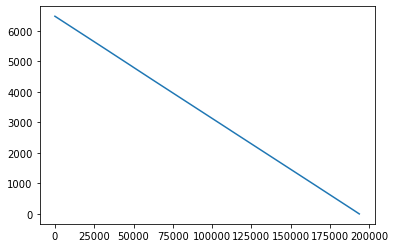

In [806]:
plt.plot(dfwb[dfwb.columns[6]])

In [807]:
dfwb

,Inlet Flowrate,Inlet Pressure,Outlet Pressure,Pump Driver Vibration,Pump Vibration,Broken_Impeller Failure,Broken_Impeller TT Failure
0,2038.95,44.0898,5589.7,0.0721289,0.0225391,1,6483.4
1,2040.16,44.1504,5585.05,0.0732161,0.0221094,1,6483.37
2,2040.94,44.1901,5592.54,0.0743359,0.0233984,1,6483.33
3,2042.58,44.1855,5595.97,0.0743848,0.0225195,1,6483.3
4,2042.4,44.1582,5592.54,0.0731055,0.0227214,1,6483.27
...,...,...,...,...,...,...,...
193577,1938.75,40.6797,4999.92,0.178438,0.0544531,1,0.133611
193578,1940,40.6875,7003.75,0.135781,0.0519922,1,0.100278
193579,1937.81,40.6406,6954.49,0.181484,0.0519922,1,0.0669444
193580,1938.75,40.5469,7050.98,0.146328,0.0504687,1,0.0336111


weights = np.ones(len(dfwb)).tolist()
weights.pop()
weights.append(10)
dfwb['Weight'] = weights
dfwb.drop('Weight',axis = 1, inplace = True)

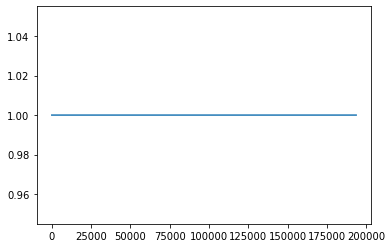

In [808]:
plt.plot(dfwb[dfwb.columns[5]])

In [809]:
aft.fit(dfwb, duration_col = f'{mode} TT Failure', event_col = f'{mode} Failure', ancillary = True)#, weights_col = 'Weight')

None


ConvergenceError: Fitting did not converge. Try the following:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Try scaling your duration vector down, i.e. `df[duration_col] = df[duration_col]/100`
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
5. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
6. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.



0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Try scaling your duration vector down, i.e. `df[duration_col] = df[duration_col]/100`
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
5. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
6. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.


In [ ]:
aft.print_summary()

dfwb.drop('Int', axis = 1, inplace = True)

labeled[availvars].iloc[0]

np.log(aft.predict_survival_function(labeled[availvars].iloc[-1]))

plt.plot(h0)

aft.plot_partial_effects_on_outcome(availvars, [[0,0,0,0,0],[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])

availvars

In [783]:
betas = aft.params_.lambda_.values
alphas = aft.params_.rho_.values

In [784]:
betas

array([-8.12418128e-03, -4.81714806e-03, -1.74334139e-03, -2.73800475e+00,
       -1.95295523e+00,  3.45678911e+01])

In [785]:
dfwb['Int'] = 1

In [786]:
xs = dfwb[availvars + ['Int']].values

In [787]:
alphas

array([0.72822969])

In [788]:
lambdax = np.exp(np.dot(xs,betas))

In [789]:
t

array([0.000000e+00, 1.200000e+02, 2.400000e+02, ..., 2.350740e+07,
       2.350872e+07, 2.350944e+07])

In [790]:
t = df['Time On'].values

In [791]:
t

array([0.000000e+00, 1.200000e+02, 2.400000e+02, ..., 1.229604e+07,
       1.229616e+07, 1.229628e+07])

In [792]:
rho = np.exp(alphas)#np.exp(np.dot(xs,alphas))
rho

array([2.07141032])

In [793]:
haz = (t/lambdax)**rho

In [794]:
survival = np.exp(-(t/lambdax)**rho)

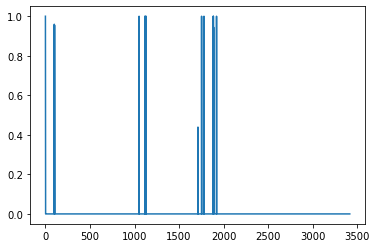

In [795]:
plt.plot(t/(60*60), survival)

print(aft.__doc__)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

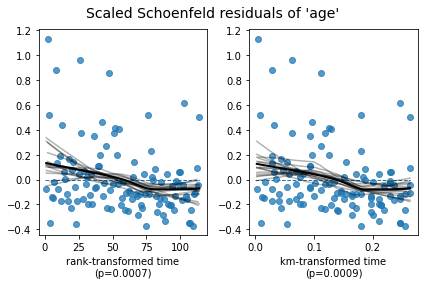

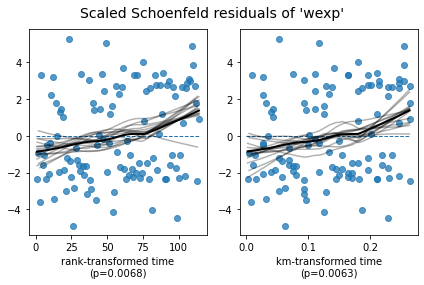

In [364]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi = load_rossi()
cph = CoxPHFitter().fit(rossi, 'week', 'arrest')

axes = cph.check_assumptions(rossi, show_plots=True)

In [365]:
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3
